In [1]:
import sys
import os
root_dir = 'C:/Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets'
sys.path.append(root_dir)

# Configure Environment
from A_Main.Configurations.setup_env import setup_environment
config = setup_environment(root_dir)

# File Paths - Raw Data
raw_data_path_train = config.raw_data_train
raw_data_path_val = config.raw_data_val
raw_data_path_test = config.raw_data_test

# File Paths - Serialised Data Object Stores 
sdo_pkl = config.sdo_pkl
sdo_parq = config.sdo_parq

glove_input_dir = config.GloVe_input_dir
glove_output_dir = config.GloVe_output_dir

In [2]:
# Libraries Import
path_dependencies = 'Libraries/dependencies.py'

dependencies_dir  = os.path.join(root_dir, path_dependencies)
with open(dependencies_dir, 'r') as file:
    exec(file.read())

In [3]:
# Class Imports
from Modularization.initial_process import InitialDataProcessing
from Modularization.initial_process import InitialTextProcessing

from Modularization.corpus_creation import CorpusBowCreator, load_corpus_bow

from Modularization.feature_extraction import FeatureExtractor

from Modularization.preprocessing import Preprocessor
from Modularization.preprocessing import Embeddings 

from Modularization.feature_engineering import FeatureEngineer

from Modularization.model_select import ModelSelection

from Modularization.model_training import ModelTrainer

from Modularization.model_evaluation import BinaryClassifierEvaluator

In [4]:
# Pipeline Parameters
fig_size = config.fig_size_m
raw_dtype = config.raw_dtype
true_dtype = config.true_dtype

drop_cols = config.drop_cols
text_col = config.text_col
token_col = config.token_col
keyword_col = config.keyword_col
target_col = config.target_col
selected_features = config.selected_features

In [5]:
# Embedding Files
glove_input_file = os.path.join(glove_input_dir, 'glove.twitter.27B.25d.txt')
word2vec_output_file = os.path.join(glove_output_dir, 'glove.twitter.27B.25d.txt.word2vec')
glove2word2vec(glove_input_file, word2vec_output_file)

embed_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\delst\AppData\Local\Temp\ipykernel_21516\1537183390.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


---

# **Raw Data Load**

In [6]:
df_train = pd.read_csv(raw_data_path_train)
df_val = pd.read_csv(raw_data_path_val)
df_test = pd.read_csv(raw_data_path_test)

---

# **Training Pipeline**

In [7]:
models = {
    'SVM': SVC(),
    'SGD': SGDClassifier(),
    'RandomForest': RandomForestClassifier(max_depth=8, n_estimators=120),
    'GBM': GradientBoostingClassifier(),
    'LGBM': LGBMClassifier(),
    'XGB': XGBClassifier()
    }

In [8]:
def training_pipeline(
    df: pd.DataFrame,
    true_dtype:dict,
    drop_cols:list,
    text_col:str,
    token_col:str,
    keyword_col:str,
    embed_n_features:int,
    selected_features,
    models
    ):
    
    # Initial Processing
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    df = initial_text_processor.remove_urls()
    df = initial_text_processor.transform_to_lowercase()
    df = initial_text_processor.apply_remove_chars()

    initial_processor = InitialDataProcessing(df)
    df = initial_processor.transform_dtypes(true_dtype)
    df = initial_processor.dup_nan_drop(drop_cols)
    
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    tokenizer = TweetTokenizer()
    df = initial_text_processor.fix_contractions()
    df = initial_text_processor.tokenize_text(tokenizer)
    
    # Corpus Creation
    
    # Feature Extraction
    feature_extractor = FeatureExtractor(df, token_col)
    df = feature_extractor.extract()
    
    # Preprocessing
    preprocessor = Preprocessor(df, token_col)
    lemmatize_tokens = preprocessor.apply_lemmatizer()
    
    embedder = Embeddings(embed_model, embed_n_features)
    glove_vectorised_tokens = embedder.averaged_word_vectorizer(df[token_col])
    glove_vectorised_keyword = embedder.averaged_word_vectorizer(df[keyword_col])
    
    # Feature Engineering
    sia = SentimentIntensityAnalyzer()
    feature_engineering = FeatureEngineer(df, token_col, text_col, sia)
    df = feature_engineering.generate_counts()
    df = feature_engineering.generate_sentiment_score()
    
    # Input Data Formulation
    target = df[target_col].to_numpy()
    numerical_features = df[selected_features].to_numpy()
    
    X_train = np.concatenate(
        (
        glove_vectorised_tokens, 
        glove_vectorised_keyword, 
        numerical_features
        ), 
        axis=1)
    
    Y_train = target
    
    # Model Selection    
    skf = StratifiedKFold(n_splits=9, random_state=42, shuffle=True)

    model_selection = ModelSelection(models, X_train, Y_train, skf)
    model_evaluation = model_selection.evaluate_models()
    # model_selection_report = model_selection.print_report()
    best_model_name = model_selection.get_best_model()

    # Model Training
    use_model = models[best_model_name]
    model_trainer = ModelTrainer(use_model, X_train, Y_train, skf)
    trained_model = model_trainer.train_model()
    
    return trained_model, embedder

embed_n_features = 25
skf_n_splits = 9
skf_random_state = 42

trained_model, embedder = training_pipeline(
    df_train, 
    true_dtype, 
    drop_cols, 
    text_col, 
    token_col, 
    keyword_col, 
    embed_n_features,
    selected_features,
    models
    )

C:\Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets\Modularization\initial_process.py:111: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df[self.text_col] = self.df[self.text_col].str.replace(r'\s*http?://\S+(\s+|$)', ' ').str.strip()


In [9]:
trained_model

LGBMClassifier()

In [10]:
embedder

---

# **Validation Pipeline**

In [11]:
def validation_pipeline(
    df: pd.DataFrame,
    true_dtype:dict,
    drop_cols:list,
    text_col:str,
    token_col:str,
    keyword_col:str,
    embed_n_features:int,
    selected_features:list,
    
    trained_model:object,
    embedder:object,
    ):
    
    # Initial Processing
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    df = initial_text_processor.remove_urls()
    df = initial_text_processor.transform_to_lowercase()
    df = initial_text_processor.apply_remove_chars()

    initial_processor = InitialDataProcessing(df)
    df = initial_processor.transform_dtypes(true_dtype)
    df = initial_processor.dup_nan_drop(drop_cols)
    
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    tokenizer = TweetTokenizer()
    df = initial_text_processor.fix_contractions()
    df = initial_text_processor.tokenize_text(tokenizer)
        
    # Feature Extraction
    feature_extractor = FeatureExtractor(df, token_col)
    df = feature_extractor.extract()
    
    # Preprocessing
    preprocessor = Preprocessor(df, token_col)
    lemmatize_tokens = preprocessor.apply_lemmatizer()
    
    glove_vectorised_tokens = embedder.averaged_word_vectorizer(df[token_col])
    glove_vectorised_keyword = embedder.averaged_word_vectorizer(df[keyword_col])
    
    # Feature Engineering
    sia = SentimentIntensityAnalyzer()
    feature_engineering = FeatureEngineer(df, token_col, text_col, sia)
    df = feature_engineering.generate_counts()
    df = feature_engineering.generate_sentiment_score()
    
    # Input Data Formulation
    y_true = df[target_col].to_numpy()
    numerical_features = df[selected_features].to_numpy()
    
    X_test = np.concatenate(
        (
        glove_vectorised_tokens, 
        glove_vectorised_keyword, 
        numerical_features
        ), 
        axis=1)
    
    y_pred = trained_model.predict(X_test)
    y_scores = trained_model.predict_proba(X_test)

    return y_true, y_pred, y_scores

embed_n_features = 25

y_true, y_pred, y_scores = validation_pipeline(
    df_val, 
    true_dtype, 
    drop_cols, 
    text_col, 
    token_col, 
    keyword_col, 
    embed_n_features,
    selected_features,
    
    trained_model,
    embedder
    )

C:\Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets\Modularization\initial_process.py:111: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df[self.text_col] = self.df[self.text_col].str.replace(r'\s*http?://\S+(\s+|$)', ' ').str.strip()


---

# **Testing Pipeline**

In [12]:
def testing_pipeline(
    df: pd.DataFrame,
    true_dtype:dict,
    drop_cols:list,
    text_col:str,
    token_col:str,
    keyword_col:str,
    embed_n_features:int,
    selected_features:list,
    
    trained_model:object,
    embedder:object,
    ):
    
    # Initial Processing
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    df = initial_text_processor.remove_urls()
    df = initial_text_processor.transform_to_lowercase()
    df = initial_text_processor.apply_remove_chars()

    initial_processor = InitialDataProcessing(df)
    df = initial_processor.transform_dtypes(true_dtype)
    df = initial_processor.dup_nan_drop(drop_cols)
    
    initial_text_processor = InitialTextProcessing(df, text_col, token_col)
    tokenizer = TweetTokenizer()
    df = initial_text_processor.fix_contractions()
    df = initial_text_processor.tokenize_text(tokenizer)
        
    # Feature Extraction
    feature_extractor = FeatureExtractor(df, token_col)
    df = feature_extractor.extract()
    
    # Preprocessing
    preprocessor = Preprocessor(df, token_col)
    lemmatize_tokens = preprocessor.apply_lemmatizer()
    
    glove_vectorised_tokens = embedder.averaged_word_vectorizer(df[token_col])
    glove_vectorised_keyword = embedder.averaged_word_vectorizer(df[keyword_col])
    
    # Feature Engineering
    sia = SentimentIntensityAnalyzer()
    feature_engineering = FeatureEngineer(df, token_col, text_col, sia)
    df = feature_engineering.generate_counts()
    df = feature_engineering.generate_sentiment_score()
    
    # Input Data Formulation
    numerical_features = df[selected_features].to_numpy()
    
    X_test = np.concatenate(
        (
        glove_vectorised_tokens, 
        glove_vectorised_keyword, 
        numerical_features
        ), 
        axis=1)
    
    predictions = trained_model.predict(X_test)

    return predictions

embed_n_features = 25

predictions = testing_pipeline(
    df_test, 
    true_dtype, 
    drop_cols, 
    text_col, 
    token_col, 
    keyword_col, 
    embed_n_features,
    selected_features,
    
    trained_model,
    embedder
    )

C:\Users/delst/OneDrive/Desktop/Code/Workspace/NLP_Disaster_Tweets\Modularization\initial_process.py:111: FutureWarning: The default value of regex will change from True to False in a future version.
  self.df[self.text_col] = self.df[self.text_col].str.replace(r'\s*http?://\S+(\s+|$)', ' ').str.strip()


In [13]:
predictions

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

---

# **Model Evaluation**

Classification Report:


,precision,recall,f1-score,support
No Disaster,0.82,0.88,0.85,870.00
Disaster,0.82,0.73,0.78,640.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.82,0.81,0.81,1510.00
weighted avg,0.82,0.82,0.82,1510.00


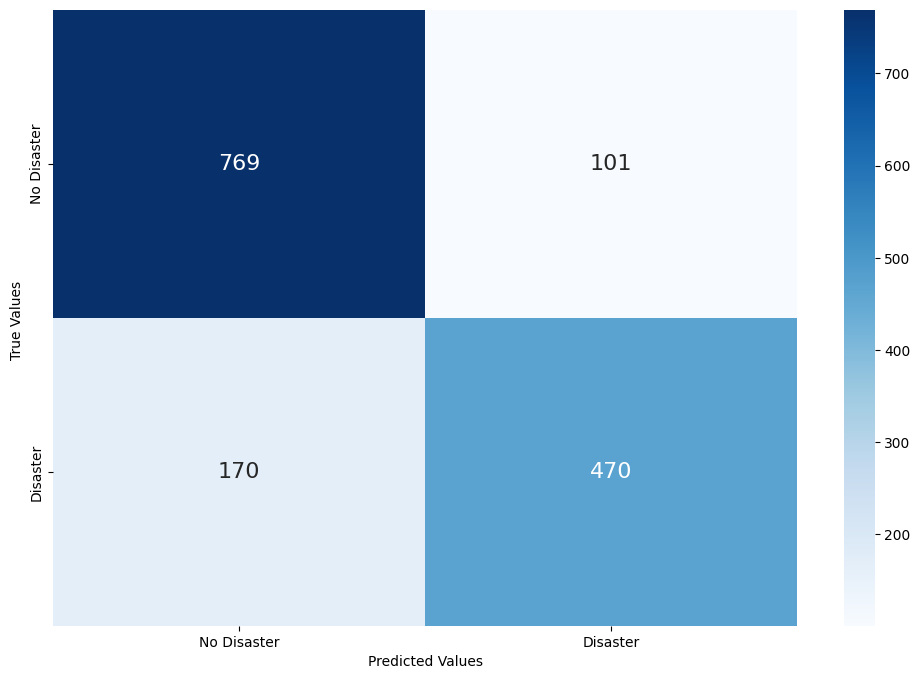

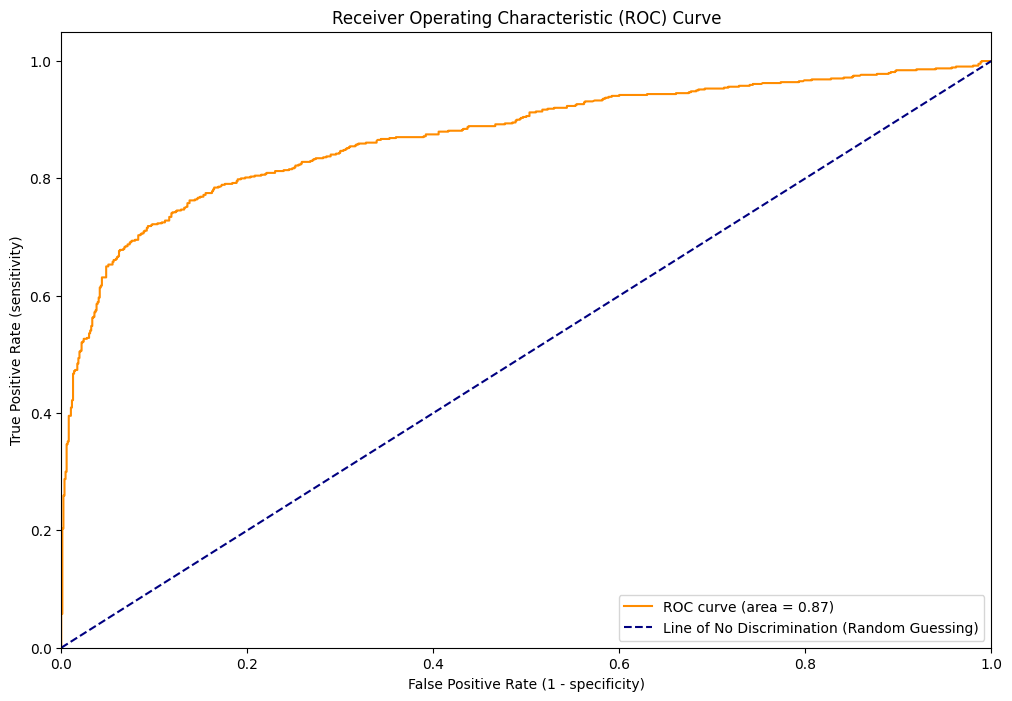

In [14]:
evaluator = BinaryClassifierEvaluator(y_true, y_pred, y_scores[:, 1])
cr = display(evaluator.create_classification_report())
cm = evaluator.visualise_confusion_matrix()
roc = evaluator.visualise_roc_curve()